# Лабораторная работа 3
## Фильтр частиц
Выполнил: Миргазов Э.Р. <br>
Группа: R4135c <br>
ИСУ: 371384
### Описание системы

В квадратной площадке длиной 100 метров находится мобильный робот. В углах площадки установлены радиомаяки. Робот может измерять расстояние до маяков. Погрешность измерений описывается нормальным распределением с нулевым математически ожиданием и погрешностью $\sigma = 15$. Известно, что начальное положение робота находится в диапазоне координат (0 -100, 0- 100). Начальная ориентация робота составляет $0 \pm 2$ градуса.

Робот функционирует следующим образом:

- Принимает от оператора требуемый угол поворота и дальность перемещения;
- Поворачивается на заданный угол;
- Проезжает заданную дистанцию;
- Измеряет расстояние до маяков;
- Рассчитывает свое положение.

Поворот робота на заданный угол происходит с нормально распределенной погрешностью с нулевым математическим ожиданием и средневадратическим отклонением $\sigma_{\theta} = 2$. Перемещение робота на заданную дистанцию происходит с нормально распределенной погрешностью с нулевым математическим ожиданием и средневадратическим отклонением $\sigma_{l} = 15$.  Требуется построить фильтр частиц для повышения точности локализации робота.

### Задание

- Задать начальное положение робота и средневадратические отклонения;
- Задать не менее 5 команд на перемещение робота;
- Построить траеткторию движения робота с учетом погрешностей;
- Построить фильтр частиц для робота;
- Построить траеткорию движения робота, положения частиц и оценку положения робота после выполнения каждой из команд;
- Выполнить предыдущие пункты для трех различных начальных положений, среднеквадратических отклонений, количества частиц и траекторий движения.

In [281]:
import numpy as np
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed)

### Зададим начальное положение робота и средневадратические отклонения <br>
Для этого будем использовать равномерное распределение

In [282]:
# случайное целое число от 0 до 100
x = np.random.randint(0, 101) 
y = np.random.randint(0, 101)

# случайное число с плавающей запятой от -2 до 2
orient = np.random.uniform(-2, 2)

print("Начальное положение робота:", x, y)
print("Начальная ориентация робота:", orient)

sigma_sens = 15
sigma_theta = 2
sigma_l = 15

Начальное положение робота: 51 92
Начальная ориентация робота: -1.2662608405353448


### Зададим 5 команд на перемещение робота

In [283]:
angle = [60, 45, -60, 30, -45] # град
dist = [100, 100, 200, 150, 100]

In [284]:
def motion(x0, y0, theta0, dist, angle):
    theta = np.rad2deg(theta0) + angle + np.random.normal(0, sigma_theta)
    theta = np.deg2rad(theta)
    l = np.random.normal(dist, sigma_l)
    x = x0 + np.cos(theta) * l
    y = y0 + np.sin(theta) * l

    theta_des = np.rad2deg(theta0) + angle
    theta_des = np.deg2rad(theta_des)
    x_des = x0 + np.cos(theta_des) * dist
    y_des = y0 + np.sin(theta_des) * dist
    return x, y, theta, x_des, y_des, theta_des

In [285]:
x_arr = [x]
y_arr = [y]
theta_arr = [orient]
x_des_arr = [x]
y_des_arr = [y]
theta_des_arr = [orient]

assert len(dist) == len(angle)

for i in range(len(dist)):
    x_temp, y_temp, theta_temp, x_des, y_des, theta_dis =\
     motion(x0=x_arr[-1], y0=y_arr[-1], theta0=theta_arr[-1],
          dist=dist[i], angle=angle[i])
    x_arr.append(x_temp)
    y_arr.append(y_temp)
    theta_arr.append(theta_temp)
    x_des_arr.append(x_des)
    y_des_arr.append(y_des)
    theta_des_arr.append(theta_dis)

### Построить траеткторию движения робота с учетом погрешностей

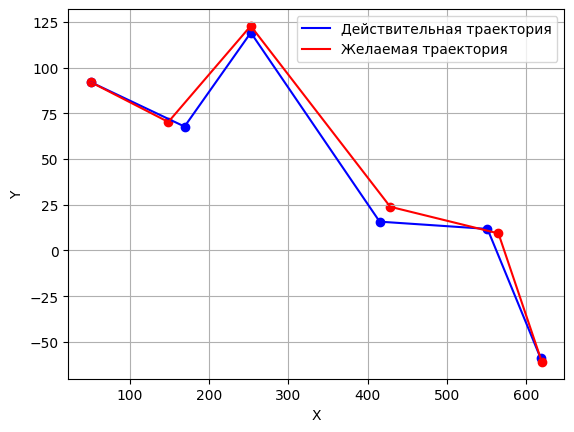

In [286]:
plt.plot(x_arr, y_arr, color='blue', label='Действительная траектория')
plt.scatter(x_arr, y_arr, color='blue', marker='o')
plt.plot(x_des_arr, y_des_arr, color='red', label='Желаемая траектория')
plt.scatter(x_des_arr, y_des_arr, color='red', marker='o')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

### Построить фильтр частиц для робота

Измерение до маяков

In [287]:
def sens(beacon, x, y, err=True):
    if err == True:
        err_sens = np.random.normal(0, sigma_sens)
    else:
        err_sens = 0

    dist = []
    for i in range(len(beacon)):
        dist.append(np.sqrt((beacon[i][0] - x) ** 2 + (beacon[i][1] - y) ** 2) + err_sens)

    return dist

Пересчет весов частиц

In [288]:
def prob(dist, sens_dist):
    p = 1
    for i in range(len(dist)):
        p *= 1 / np.sqrt(2 * np.pi * sigma_sens) *\
              np.exp(-(dist[i] - sens_dist[i])**2 / sigma_sens)
    return p

In [289]:
def weight_calc(n_part, beacon, particles, weights, robot_meas):
    for i in range(n_part):
        particle_dist = sens(beacon, particles[i, 0], particles[i, 1], err=False)
        weights[i] = prob(particle_dist, robot_meas)
    weights = weights / np.sum(weights)

    return weights

Отсев 

In [290]:
def resample(particles, weights):
    newParticles = []
    newWeights = []
    index = np.random.randint(0, len(particles))
    betta = 0
    for _ in range(len(particles)):
        # weights = np.where(np.isnan(weights), 1e-100, weights)
        betta = betta + np.random.uniform(0, 2*max(weights))
        while betta > weights[index]:
            betta = betta - weights[index]
            index = (index + 1) % len(particles)
        newParticles.append(particles[index])
        newWeights.append(weights[index])
    newWeights = newWeights / np.sum(newWeights)

    return np.array(newParticles), newWeights

Получение оценки состояния объекта

In [291]:
def estimation(particles, weights):
    est_x = 0
    est_y = 0
    for i in range(len(particles)):
        est_x += particles[i, 0] * weights[i]
        est_y += particles[i, 1] * weights[i]
    return est_x, est_y

Зададим координаты маяков

In [292]:
beacon = [[0, 0],
          [1000, 0],
          [1000, 1000],
          [0, 1000],
          [0, 500],
          [500, 0]]

In [293]:
def part_filt(n_part, x, y, orient, dist, angle, beacon):
    particles = np.zeros((n_part, 3))

    for i in range(n_part):
        particles[i][0] = np.random.randint(0, 101)
        particles[i][1] = np.random.randint(0, 101)
        particles[i][2] = np.random.uniform(-2, 2)

    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
    axs = axs.flatten()
    plt.subplots_adjust(hspace=0.25, wspace=0.15)
    axs[0].scatter(particles[:, 0], particles[:, 1], c='grey', marker='.', s=1, 
                label='Частицы')

    weights = np.ones(n_part, dtype='float64') / n_part

    robot_meas = sens(beacon, x, y)
    weights = weight_calc(n_part, beacon, particles, weights, robot_meas)
    particles, weights = resample(particles, weights)
    x_est, y_est = estimation(particles, weights)

    x_true_arr, y_true_arr = [x], [y]
    x_est_arr, y_est_arr = [x_est], [y_est]

    axs[0].scatter(x_true_arr, y_true_arr, color='blue', marker='o',
                label='Действительное положение')
    axs[0].scatter(particles[:, 0], particles[:, 1], c='r', marker='.', s=1,
                label='Частицы после отсева')
    axs[0].set_xlim(0, 100)
    axs[0].set_ylim(0, 100)
    axs[0].set_title('Оценка начального \n положения')
    fig.legend(loc='upper right')
    fig.suptitle('Положение частиц после \n выполнения каждой из команд')

    for move in range(len(angle)):
        x, y, orient, _, _, _ =\
        motion(x, y, orient, dist=dist[move], angle=angle[move])
        x_true_arr.append(x)
        y_true_arr.append(y)

        for i in range(n_part):
            particles[i, 0], particles[i, 1], particles[i, 2], _, _, _ =\
                motion(particles[i, 0], particles[i, 1], particles[i, 2],
                dist=dist[move], angle=angle[move])

        axs[move+1].scatter(particles[:, 0], particles[:, 1], c='grey', marker='.', s=1)

        robot_meas = sens(beacon, x, y)
        weights = weight_calc(n_part, beacon, particles, weights, robot_meas)
        particles, weights = resample(particles, weights)

        x_est, y_est = estimation(particles, weights)
        x_est_arr.append(x_est)
        y_est_arr.append(y_est)

        axs[move+1].scatter(x_true_arr[-1], y_true_arr[-1], color='blue', marker='o')
        axs[move+1].scatter(particles[:, 0], particles[:, 1], c='r', marker='.', s=0.01)
        axs[move+1].set_title('step = {}'.format(move+1))
    
    return x_true_arr, y_true_arr, x_est_arr, y_est_arr


### Построение положения частиц после выполнения каждой из команд

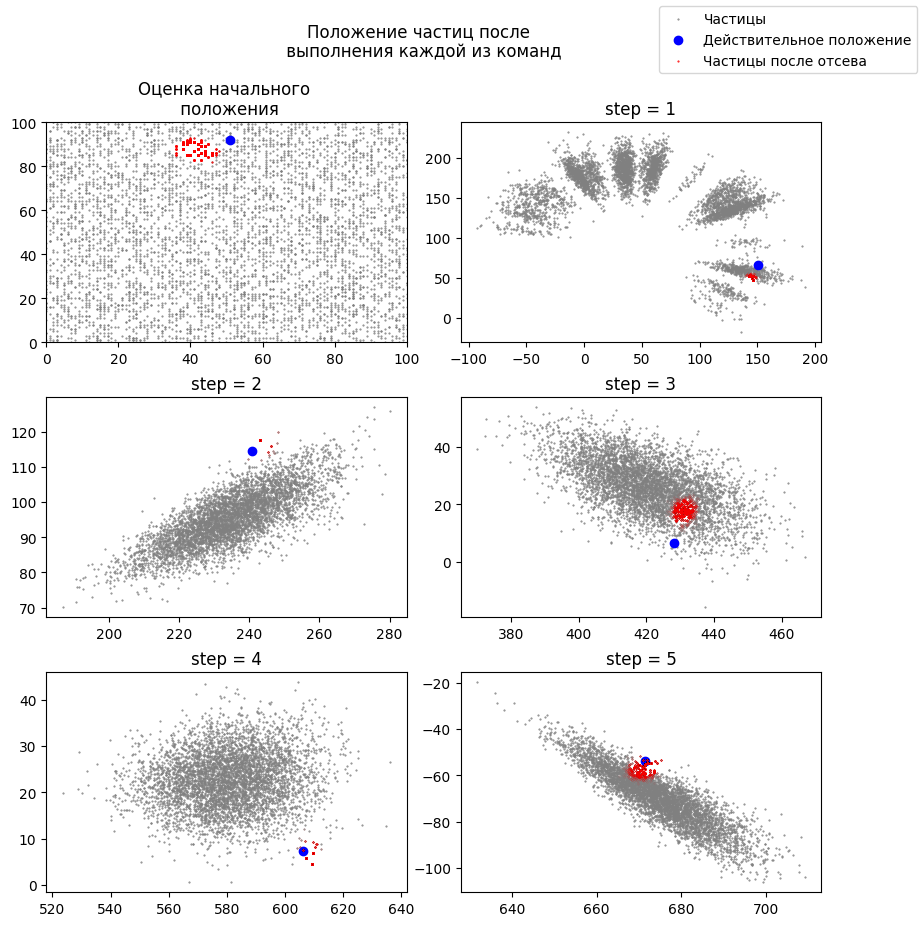

In [294]:
n_part = 5000

x_true_arr, y_true_arr, x_est_arr, y_est_arr =\
    part_filt(n_part, x, y, orient, dist, angle, beacon)

### Построение траектории движения и оценку положения робота

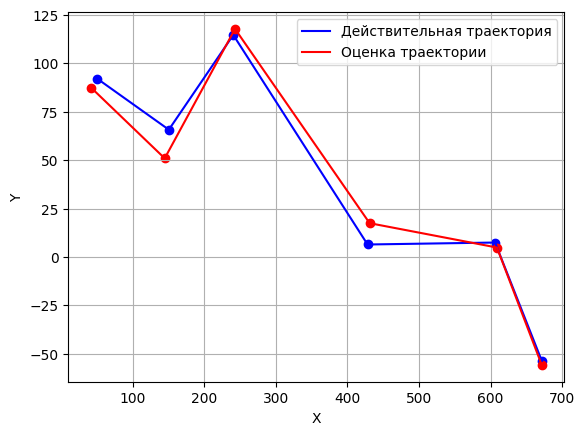

In [295]:
plt.plot(x_true_arr, y_true_arr, color='blue', label='Действительная траектория')
plt.scatter(x_true_arr, y_true_arr, color='blue', marker='o')
plt.plot(x_est_arr, y_est_arr, color='red', label='Оценка траектории')
plt.scatter(x_est_arr, y_est_arr, color='red', marker='o')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

### Построим траеткорию движения робота, положения частиц и оценку положения робота после выполнения каждой из команд для трех различных начальных положений, среднеквадратических отклонений, количества частиц и траекторий движения

1

In [296]:
x = np.random.randint(0, 101) 
y = np.random.randint(0, 101)
orient = np.random.uniform(-2, 2)
print("Начальное положение робота:", x, y)
print("Начальная ориентация робота:", orient)

sigma_sens = 12
sigma_theta = 1
sigma_l = 12

angle = [np.random.randint(-90, 90) for _ in range(5)]
dist = [np.random.randint(30, 100) for _ in range(5)]
print('Углы поворота', angle)
print('Перемещения', dist)

n_part = 4000

Начальное положение робота: 27 86
Начальная ориентация робота: -1.2231707410418724
Углы поворота [-24, 36, -53, -67, -79]
Перемещения [38, 30, 49, 85, 61]


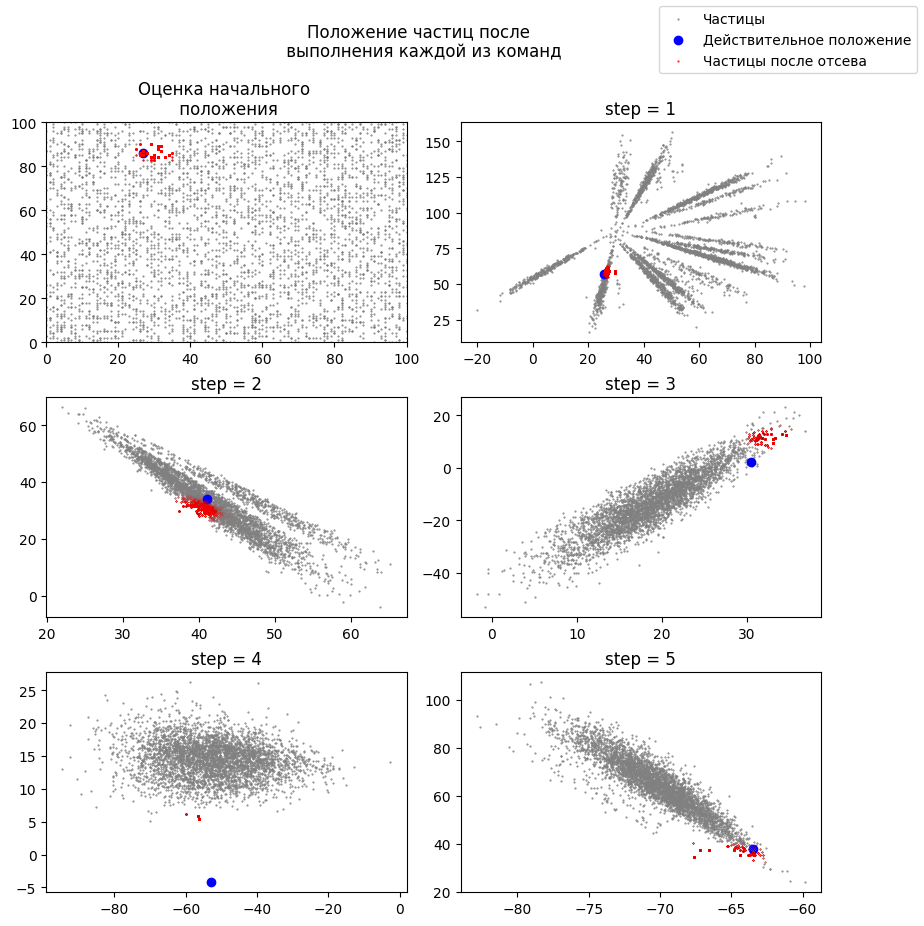

In [297]:
x_true_arr, y_true_arr, x_est_arr, y_est_arr =\
    part_filt(n_part, x, y, orient, dist, angle, beacon)

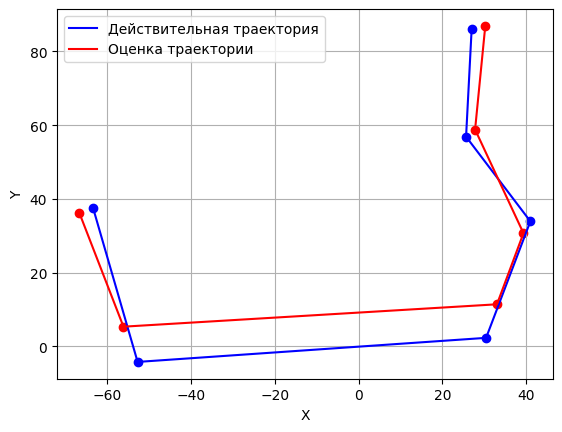

In [298]:
plt.plot(x_true_arr, y_true_arr, color='blue', label='Действительная траектория')
plt.scatter(x_true_arr, y_true_arr, color='blue', marker='o')
plt.plot(x_est_arr, y_est_arr, color='red', label='Оценка траектории')
plt.scatter(x_est_arr, y_est_arr, color='red', marker='o')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

2

In [299]:
x = np.random.randint(0, 101) 
y = np.random.randint(0, 101)
orient = np.random.uniform(-2, 2)
print("Начальное положение робота:", x, y)
print("Начальная ориентация робота:", orient)

sigma_sens = 10
sigma_theta = 1
sigma_l = 10

angle = [np.random.randint(-90, 90) for _ in range(5)]
dist = [np.random.randint(30, 100) for _ in range(5)]
print('Углы поворота', angle)
print('Перемещения', dist)

n_part = 3000

Начальное положение робота: 16 30
Начальная ориентация робота: 1.0795414881855767
Углы поворота [-84, -32, 70, -65, -21]
Перемещения [63, 36, 75, 85, 44]


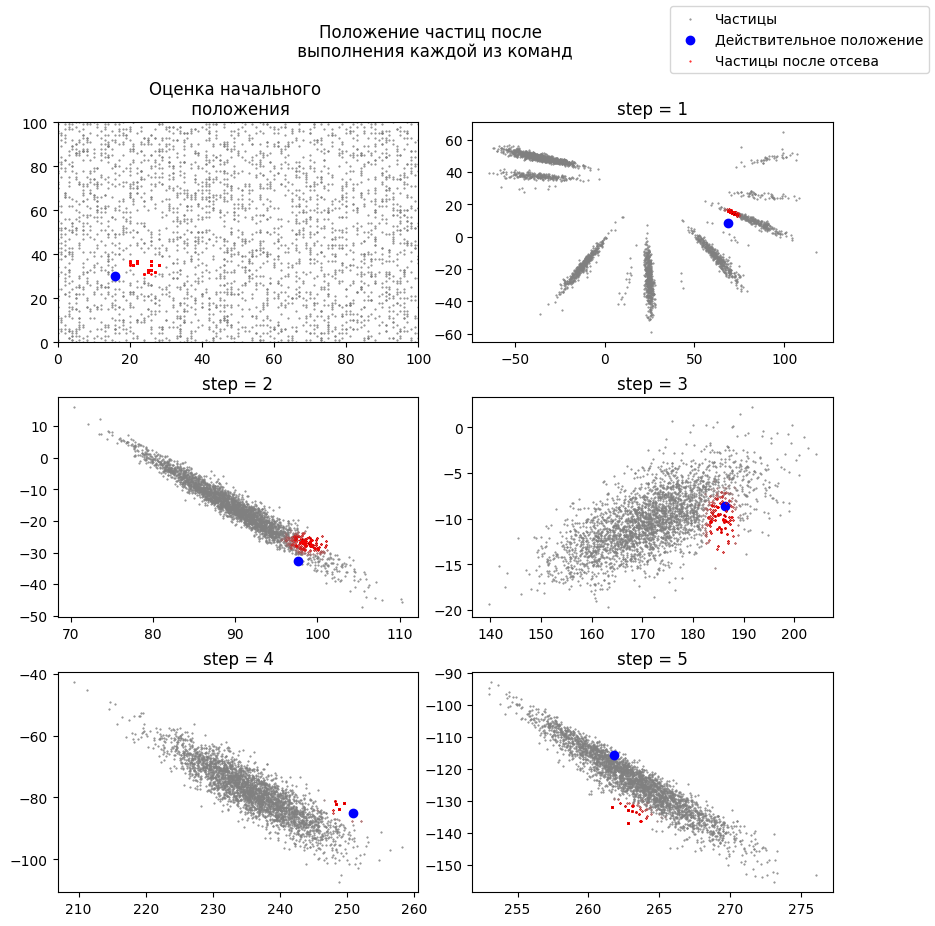

In [300]:
x_true_arr, y_true_arr, x_est_arr, y_est_arr =\
    part_filt(n_part, x, y, orient, dist, angle, beacon)

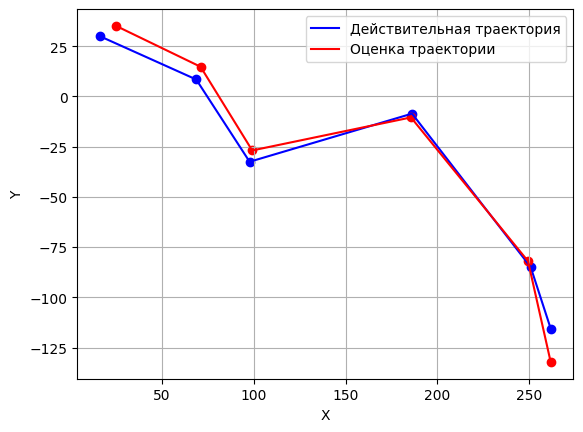

In [301]:
plt.plot(x_true_arr, y_true_arr, color='blue', label='Действительная траектория')
plt.scatter(x_true_arr, y_true_arr, color='blue', marker='o')
plt.plot(x_est_arr, y_est_arr, color='red', label='Оценка траектории')
plt.scatter(x_est_arr, y_est_arr, color='red', marker='o')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

3

In [302]:
x = np.random.randint(0, 101) 
y = np.random.randint(0, 101)
orient = np.random.uniform(-2, 2)
print("Начальное положение робота:", x, y)
print("Начальная ориентация робота:", orient)

sigma_sens = 17
sigma_theta = 3
sigma_l = 17

angle = [np.random.randint(-90, 90) for _ in range(5)]
dist = [np.random.randint(30, 100) for _ in range(5)]
print('Углы поворота', angle)
print('Перемещения', dist)

n_part = 2000

Начальное положение робота: 83 22
Начальная ориентация робота: 1.873105785917926
Углы поворота [-21, -50, -81, -68, 11]
Перемещения [44, 76, 75, 68, 31]


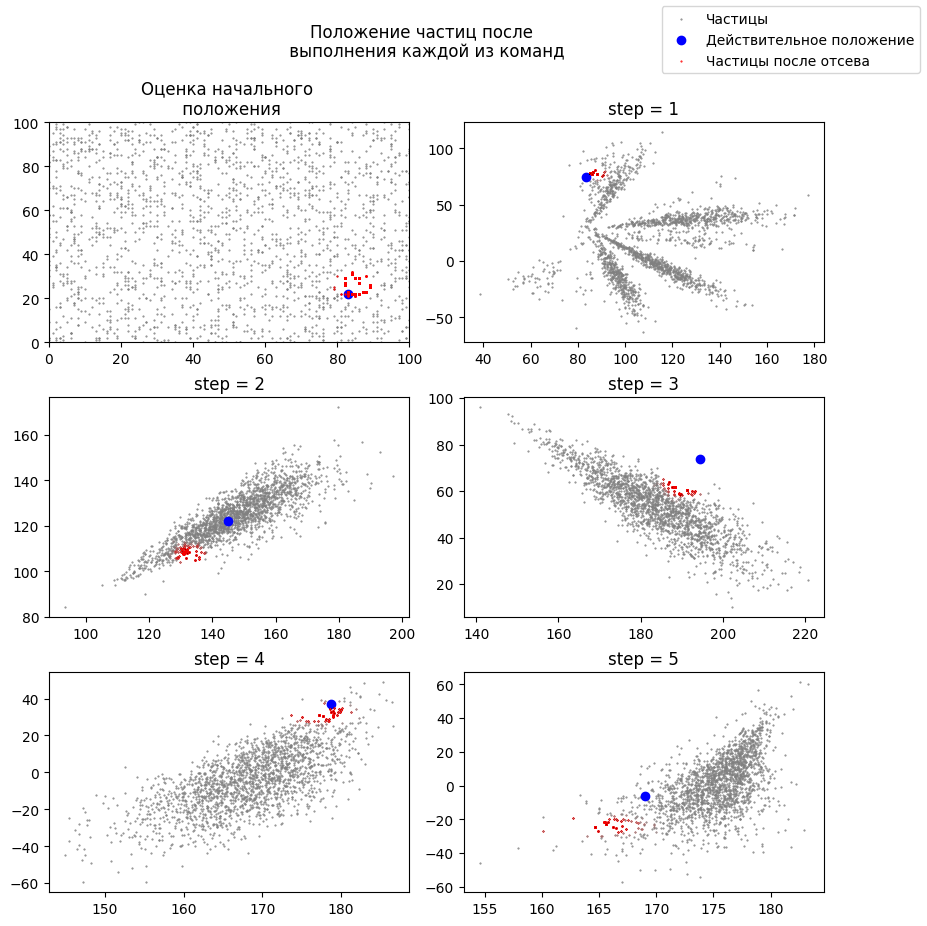

In [303]:
x_true_arr, y_true_arr, x_est_arr, y_est_arr =\
    part_filt(n_part, x, y, orient, dist, angle, beacon)

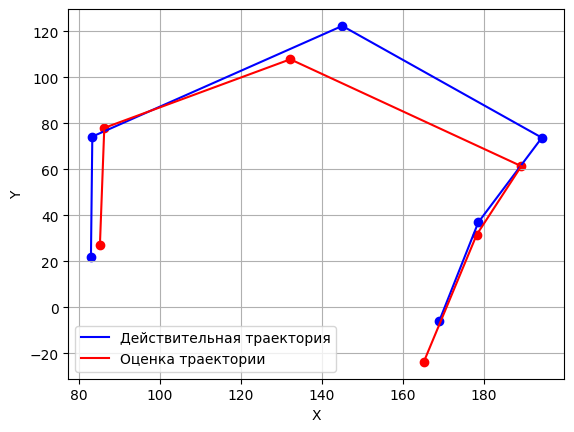

In [304]:
plt.plot(x_true_arr, y_true_arr, color='blue', label='Действительная траектория')
plt.scatter(x_true_arr, y_true_arr, color='blue', marker='o')
plt.plot(x_est_arr, y_est_arr, color='red', label='Оценка траектории')
plt.scatter(x_est_arr, y_est_arr, color='red', marker='o')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

### Выводы
В ходе выполненя лабораторной работы было промоделировано движение робота на плоской карте с неидеальными актуаторами из-за чего поворот робота на заданный угол и перемещение на заданное расстояние происходит с нормальной распределенной погрешностью. Для определения позиции робота использовались маяки, расположенные на карте и замер расстояния до маяков также происходит с нормальной распределенной погрешностью. 
Для оценки параметров состояния системы, в нашем случае координат и ориентации, использовался фильтр частиц. Данный фильтр использует измерения связанных параметров и для оценки создает множество частиц, некоторая часть которых с ростом итераций будет убираться ввиду малой достоверности, а другая часть будем сохраняться. Таким образом должны остаться только наиболее достоверные оценки положения робота. <br>
Подводя итоги можно отметить, что данный алгоритм себя хорошо показал при разных значения ско ошибок актуаторов и сенсоров, а также количества частиц. Однако нельзя не отметить, что наиболее удачный результаты получились при наименьших значениях ско и большом количестве частиц, что было ожидаемо.